# Interação intermolecular entre duas moléculas de água

Neste exercício, você realizará a mesma análise que fizemos com o método supermolecular e vamos obter a energia de interação SAPT0 entre duas molélculas de água. Vamos utilizar o dímero de água com a seguinte geometria molecular:
![image](water_dimer.png)

In [10]:
import sys; sys.path.append("/usr/lib/x86_64-linux-gnu/") 
import time
import numpy as np
import scipy
from scipy.optimize import *
np.set_printoptions(precision=5, linewidth=200, threshold=2000, suppress=True)
import psi4
import matplotlib.pyplot as plt

# Set Psi4 & NumPy Memory Options
psi4.set_memory('1 GB')
psi4.core.set_output_file('output.dat', False)

numpy_memory = 2

psi4.set_options({'basis': 'aug-cc-pVDZ',
              'e_convergence': 1e-10,
              'd_convergence': 1e-10,
              'INTS_TOLERANCE': 1e-15})

Vamos escolher as mesmas distâncias

In [24]:
distances_h2o = [2.0,2.7,3.0,3.5,4.0,4.5,5.0,6.0,7.0,8.0,9.0,10.0]

eelst = np.zeros((12))
eexch = np.zeros((12))
eind = np.zeros((12))
edisp = np.zeros((12))
esapt = np.zeros((12))


for i in range(len(distances_h2o)):
  dimero_H2O = psi4.geometry("""
  O1
  H1 O1 0.96
  H2 O1 0.96 H1 104.5
  --
  O2 O1 """+str(distances_h2o[i])+""" H1 5.0 H2 0.0
  X O2 1.0 O1 120.0 H2 180.0
  H3 O2 0.96 X 52.25 O1 90.0
  H4 O2 0.96 X 52.25 O1 -90.0
  units angstrom
  symmetry c1
  """)
  

  # calcula a energia
  psi4.energy('sapt0')
  eelst[i] = psi4.variable('SAPT ELST ENERGY') * 627.509
  eexch[i] = psi4.variable('SAPT EXCH ENERGY') * 627.509
  eind[i] = psi4.variable('SAPT IND ENERGY') * 627.509
  edisp[i] = psi4.variable('SAPT DISP ENERGY') * 627.509
  esapt[i] = psi4.variable('SAPT TOTAL ENERGY') * 627.509
 
 

  psi4.core.clean()


Agora vamos plotar as curvas SAPT

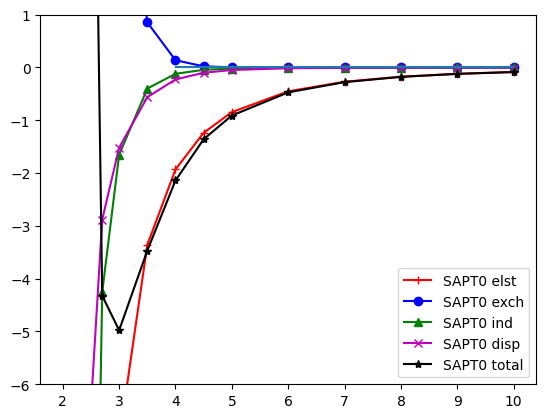

In [26]:
plt.close()
plt.ylim(-6.0,1.0)
plt.plot(distances_h2o,eelst,'r+',linestyle='-',label='SAPT0 elst')
plt.plot(distances_h2o,eexch,'bo',linestyle='-',label='SAPT0 exch')
plt.plot(distances_h2o,eind,'g^',linestyle='-',label='SAPT0 ind')
plt.plot(distances_h2o,edisp,'mx',linestyle='-',label='SAPT0 disp')
plt.plot(distances_h2o,esapt,'k*',linestyle='-',label='SAPT0 total')
plt.hlines(0.0,4.0,10.0)
plt.legend(loc='best')
plt.show()

*Questionamentos* 
1. Qual é a origem da atração entre as duas moléculas de água na orientação selecionada?
2. Para os termos que são de longo alcance e decaem com $R$ com uma lei de potência do tipo $R^{-n}$, estime $n$ ajustando a função adequada sobre os ultimos cinco pontos com os maiores valores de $R$, como fizemos no caso dos átomos de Hélio interagindo (usando o `scipy.optimize.curve_fit` ). Como explicariamos a potência de $n$ para a energia eletrostática?

In [6]:
for i in range(len(distances_h2o)):
    print(i,eelst[i])

0 -24.44743479872157
1 -3.7924256809812245
2 -1.3525665946631151
3 -0.6533169681260175
4 -0.36705824292255546
5 -0.2272945007834354
6 -0.15069502758364223
7 -0.10513214751272337
8 -0.07630391183438275
9 -0.0571588135576737
10 -0.04393890812777483
11 -0.03451260524389826


Agora vamos elencar os últimos cinco valores de energia e ajustar a função $w(R)=-\frac{C_{elst}}{R^{6}}$.

O expoente da lei de Potências é: 1.9074718257990977
O coeficiente de dispersão é: 3.463290215085875
O valor de y0 é: 0.008394813581513446


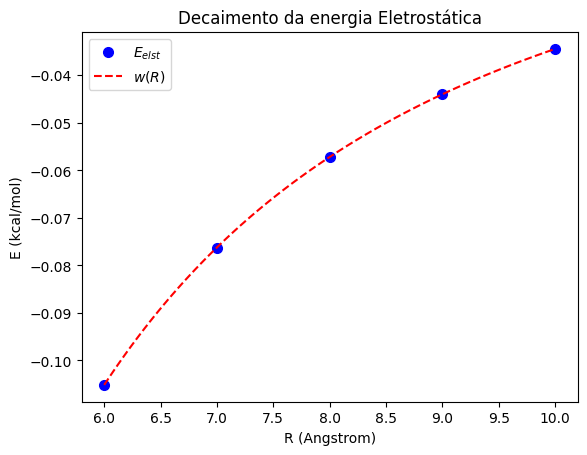

In [7]:
def func(x, n, Celst, y0):
  return -Celst*x**(-n)+y0

# Data
R = np.array([6.0, 7.0, 8.0, 9.0, 10.0])
E = np.array([-0.10513214751272337, -0.07630391183438275, -0.0571588135576737, -0.04393890812777483, -0.03451260524389826])

# Fit the function
popt, pcov = curve_fit(func, R, E)

# Print the value of n
print(f"O expoente da lei de Potências é: {popt[0]}")
print(f"O coeficiente de dispersão é: {popt[1]}")
print(f"O valor de y0 é: {popt[2]}")

# Plot the data points
plt.plot(R, E, 'o', markersize=7, color='blue', label='$E_{elst}$')

# Plot the fitted function
x_fit = np.linspace(6, 10, 100)
y_fit = func(x_fit, popt[0], popt[1], popt[2])
plt.plot(x_fit, y_fit, '--', color='red', label='$w(R)$')

# Set the labels and title of the plot
plt.xlabel('R (Angstrom)')
plt.ylabel('E (kcal/mol)')
plt.title('Decaimento da energia Eletrostática')

# Show the plot
plt.legend()
plt.show()

A molécula de água é polar - cada uma tem um momento de dipolo não-nulo e em grandes distâncias esperamos que a energia eletrostática seja dominada pela interação dipolo-dipolo (em distâncias mais curtas, quando os orbtiais das duas moléculas começam a se superpor, a aproximação multipolar não é mais válida e a eenrgia eletrostática contém um termo de curto-alcance chamado de *penetração de carga*). Vamos checar se isto é de fato o caso. Na preparação para esta análise, iremos primeiro, encontrar o vetor de momento de dipolo de cada molécula de água no nível HF.

In [8]:
waterA = psi4.geometry("""
O 0.116724185090 1.383860971547 0.000000000000
H 0.116724185090 0.423860971547 0.000000000000
H -0.812697549673 1.624225775439 0.000000000000
units angstrom
noreorient
nocom
symmetry c1
""")

comA = waterA.center_of_mass()
comA = np.array([comA[0],comA[1],comA[2]])
E, wfn = psi4.energy('HF',return_wfn=True)
dipoleA = np.array([psi4.variable('SCF DIPOLE X'),psi4.variable('SCF DIPOLE Y'),
                    psi4.variable('SCF DIPOLE Z')])*0.393456   # conversion from Debye to a.u.
psi4.core.clean()
print("COM A in a.u.",comA)
print("Dipole A in a.u.",dipoleA)

waterB = psi4.geometry("""
O -0.118596320329 -1.305864713301 0.000000000000
H 0.362842754701 -1.642971982825 -0.759061990794
H 0.362842754701 -1.642971982825 0.759061990794
units angstrom
noreorient
nocom
symmetry c1
""")

comB = waterB.center_of_mass()
comB = np.array([comB[0],comB[1],comB[2]])
E, wfn = psi4.energy('HF',return_wfn=True)
dipoleB = np.array([psi4.variable('SCF DIPOLE X'),psi4.variable('SCF DIPOLE Y'),
                    psi4.variable('SCF DIPOLE Z')])*0.393456   # conversion from Debye to a.u.
psi4.core.clean()
print("COM B in a.u.",comB)
print("Dipole B in a.u.",dipoleB)

comA_to_comB = comB - comA
print("Vector from COMA to COMB:",comA_to_comB)

COM A in a.u. [0.1223  2.53902 0.     ]
Dipole A in a.u. [-0.61757 -0.47817 -0.     ]
COM B in a.u. [-0.1223  -2.53902  0.     ]
Dipole B in a.u. [ 0.6398  -0.44799 -0.     ]
Vector from COMA to COMB: [-0.24459 -5.07804  0.     ]


Nosso objetivo agora é plotar a energia eletrostática do SAPT em função da energia de interação entre dois dipolos the interaction energy between two dipoles $\boldsymbol{\mu_A}$ and $\boldsymbol{\mu_B}$:

\begin{equation}
E_{\rm dipole-dipole}=\frac{\boldsymbol{\mu_A}\cdot\boldsymbol{\mu_B}}{R^3}-\frac{3(\boldsymbol{\mu_A}\cdot{\mathbf R})(\boldsymbol{\mu_B}\cdot{\mathbf R})}{R^5} 
\end{equation}

Vamos programar esta fórmula na função `dipole_dipole` abaixo, empregando ${\mathbf R}$, $\boldsymbol{\mu_A}$, e $\boldsymbol{\mu_B}$ em unidades atômicas e Calculamos a energia de interação dipolo-dipolo, também em unidades atômicas (que converteremos posteriormente para kcal/mol). 
Com sua nova função, podemos popular o `edipdip` arraydas energias de interação dipolo-dipolo para todas as separações intermoleculares, e plotar estas energias junto com a verdadeira eneregia de interação eletrostática obtidas com o método SAPT. 

Note que ${\mathbf R}$ é o veto do centro de massa da molécula A para o centro de massa da molécula B. Para a menor distância intermolecular, as coordenadas atômicas são listadas no cídigo acima, `R = comA_to_comB`. Para qualquer outra distância, nós obtemos a geometria do complexo deslocando uma molécula de água para longe da outra ao longo da direção O-), então precisamos deslocar o centro de massa da segunda molécula da mesma forma.

In [9]:
#the geometries are related to each other by a shift of 1 molecule along the O-O vector:
OA_to_OB = (np.array([-0.118596320329,-1.305864713301,0.000000000000])-np.array(
    [0.116724185090,1.383860971547,0.000000000000]))/0.529177249
OA_to_OB_unit = OA_to_OB/np.sqrt(np.sum(OA_to_OB*OA_to_OB))
print("Vector from OA to OB:",OA_to_OB,OA_to_OB_unit)

def dipole_dipole(R,dipA,dipB):
#COMPLETE the definition of the dipole-dipole energy. All your data are in atomic units.

edipdip = []
for i in range(len(distances_h2o)):
  shiftlength = (distances_h2o[i]-distances_h2o[0])/0.529177249
  R = comA_to_comB + shiftlength*OA_to_OB_unit
  edipdip.append(dipole_dipole(R,dipoleA,dipoleB)*627.509)

edipdip = np.array(edipdip)
print (edipdip)

plt.close()
plt.ylim(-10.0,10.0)
plt.plot(distances_h2o,eelst_h2o,'r+',linestyle='-',label='SAPT0 elst')
plt.plot(distances_h2o,edipdip,'bo',linestyle='-',label='dipole-dipole')
plt.hlines(0.0,2.5,9.0)
plt.legend(loc='upper right')
plt.show()

IndentationError: expected an indented block after function definition on line 7 (2969593523.py, line 10)